# Bibliotekos

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter

# Failo skaitymas

In [90]:

# Perskaitome failą
df = pd.read_csv("spam.csv", encoding="latin-1")

df = df.iloc[:, :2]  # pasirenkam tik pirmus du stulpelius
df.columns = ['label', 'text']  # pervadinam, jei reikia

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [91]:
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

print(df.head())

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


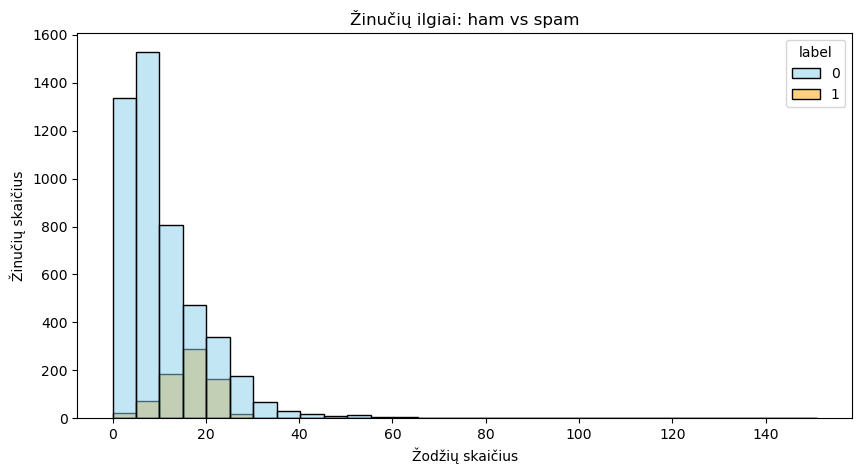

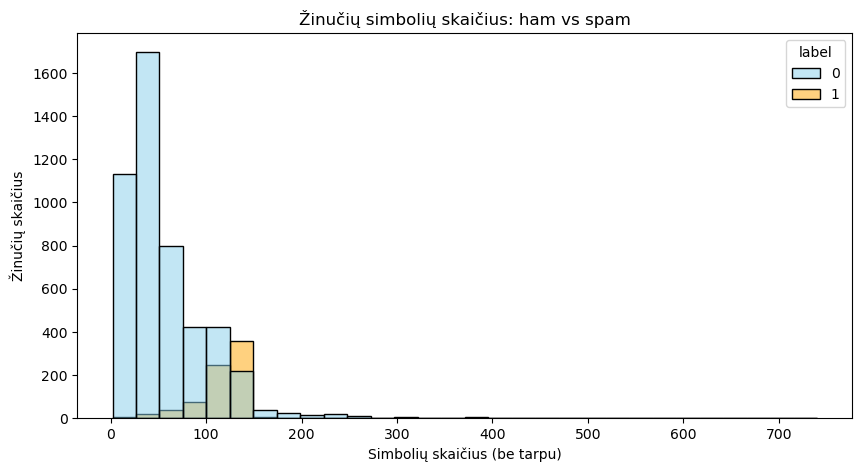

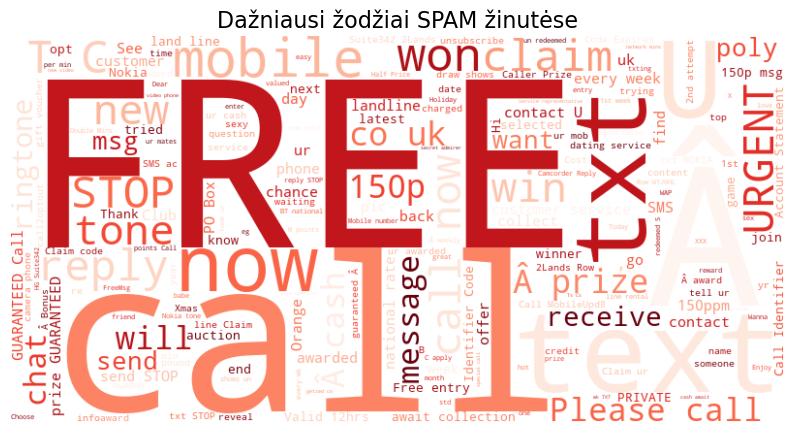

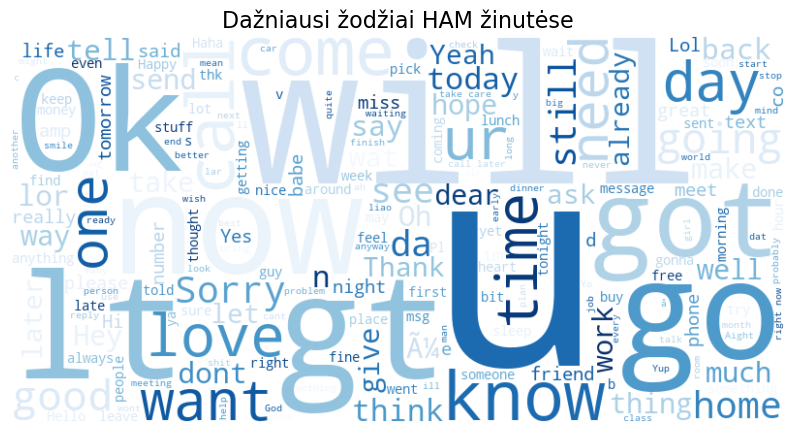

In [92]:
df['word_count'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isalpha()]))

# Character count (be tarpų)
df['char_count'] = df['text'].apply(lambda x: len(str(x).replace(" ", "")))

# 3️⃣ Histogramos žodžių skaičiui
plt.figure(figsize=(10,5))
sns.histplot(df, x='word_count', hue='label', bins=30, kde=False, palette={0:'skyblue', 1:'orange'})
plt.xlabel("Žodžių skaičius")
plt.ylabel("Žinučių skaičius")
plt.title("Žinučių ilgiai: ham vs spam")
plt.show()

# 4️⃣ Histogramos simbolių skaičiui
plt.figure(figsize=(10,5))
sns.histplot(df, x='char_count', hue='label', bins=30, kde=False, palette={0:'skyblue', 1:'orange'})
plt.xlabel("Simbolių skaičius (be tarpu)")
plt.ylabel("Žinučių skaičius")
plt.title("Žinučių simbolių skaičius: ham vs spam")
plt.show()

# 5️⃣ WordCloud – dažniausi žodžiai ham ir spam
spam_text = " ".join(df[df['label']==1]['text'].astype(str))
ham_text = " ".join(df[df['label']==0]['text'].astype(str))

# Spam WordCloud
plt.figure(figsize=(10,6))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Dažniausi žodžiai SPAM žinutėse", fontsize=16)
plt.show()

# Ham WordCloud
plt.figure(figsize=(10,6))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title("Dažniausi žodžiai HAM žinutėse", fontsize=16)
plt.show()

In [93]:
# Sukuriame naują DataFrame kopiją
df_sw = df.copy()

# Funkcija stopwords filtravimui
def remove_stopwords(text):
    words = text.lower().split()  # paverskime mažosiomis raidėmis ir padalinkime į žodžius
    filtered_words = [w for w in words if w.isalpha() and w not in ENGLISH_STOP_WORDS]  # pašaliname stopwords ir simbolius
    return " ".join(filtered_words)

# Taikome funkciją visam stulpeliui
df_sw['text'] = df_sw['text'].apply(remove_stopwords)

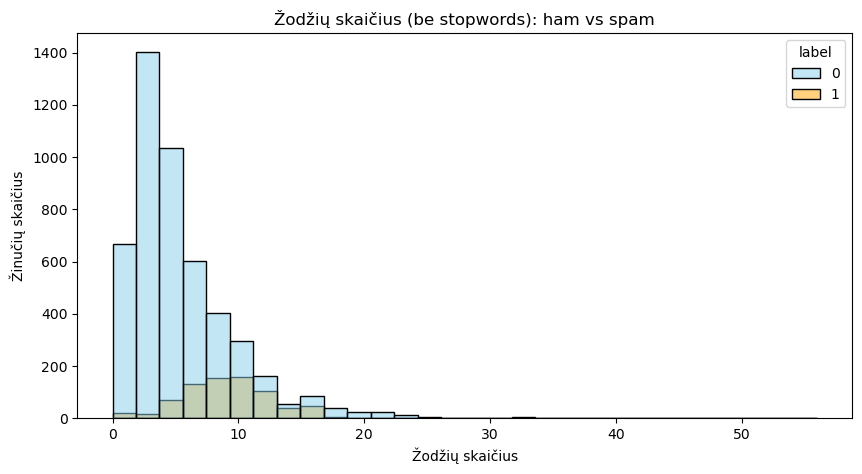

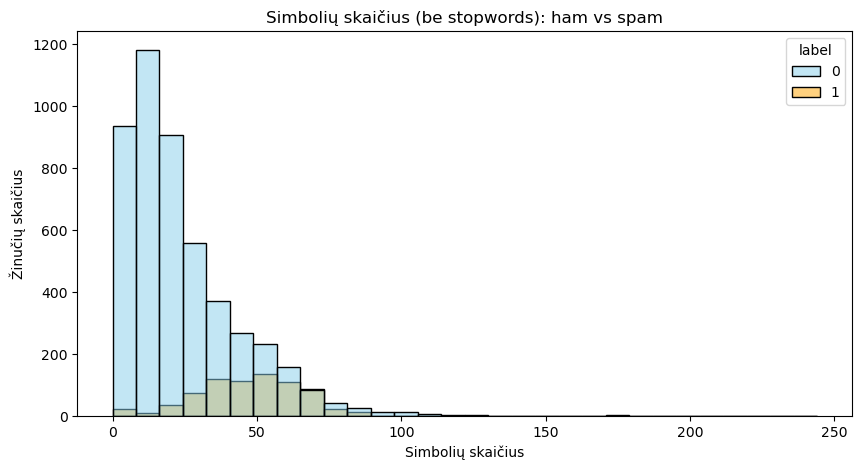

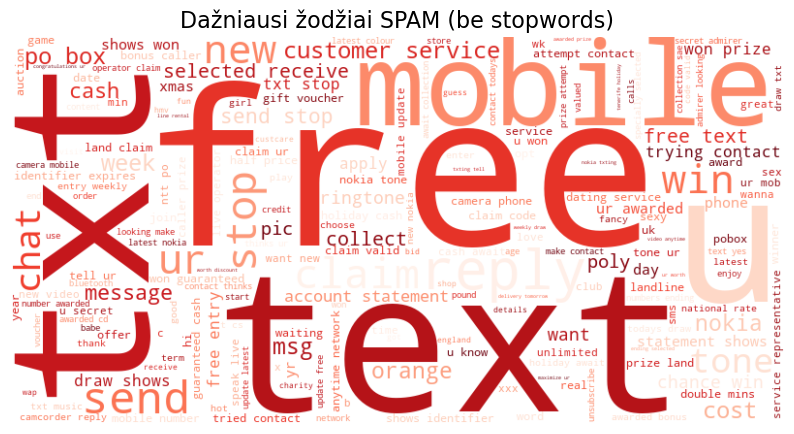

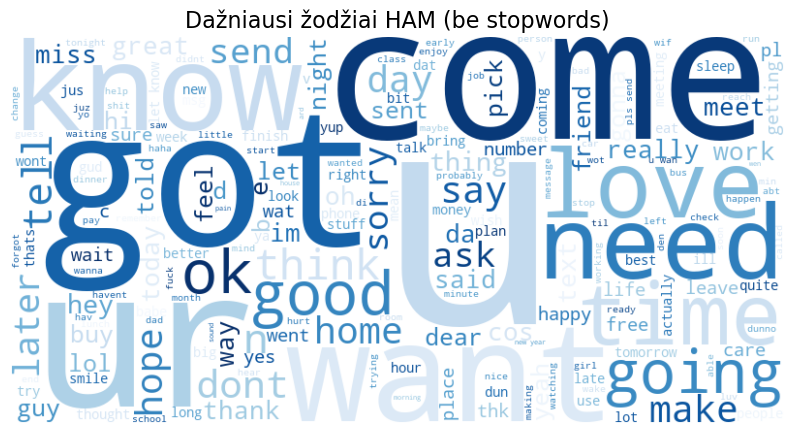

In [94]:
# 1️⃣ Skaičiuojame žodžių ir simbolių skaičių
df_sw['word_count'] = df_sw['text'].apply(lambda x: len(str(x).split()))
df_sw['char_count'] = df_sw['text'].apply(lambda x: len(str(x).replace(" ", "")))

# 2️⃣ Histogramos
plt.figure(figsize=(10,5))
sns.histplot(df_sw, x='word_count', hue='label', bins=30, palette={0:'skyblue',1:'orange'})
plt.title("Žodžių skaičius (be stopwords): ham vs spam")
plt.xlabel("Žodžių skaičius")
plt.ylabel("Žinučių skaičius")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df_sw, x='char_count', hue='label', bins=30, palette={0:'skyblue',1:'orange'})
plt.title("Simbolių skaičius (be stopwords): ham vs spam")
plt.xlabel("Simbolių skaičius")
plt.ylabel("Žinučių skaičius")
plt.show()

# 3️⃣ WordCloud
spam_text = " ".join(df_sw[df_sw['label']==1]['text'])
ham_text = " ".join(df_sw[df_sw['label']==0]['text'])

# Spam WordCloud
plt.figure(figsize=(10,6))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(spam_text)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Dažniausi žodžiai SPAM (be stopwords)", fontsize=16)
plt.show()

# Ham WordCloud
plt.figure(figsize=(10,6))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ham_text)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title("Dažniausi žodžiai HAM (be stopwords)", fontsize=16)
plt.show()

# 4️⃣ Top 20 žodžių bar chart
def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    counter = Counter(words)
    return counter.most_common(n)

top_spam = get_top_words(df_sw[df_sw['label']==1]['text'])
top_ham = get_top_words(df_sw[df_sw['label']==0]['text'])


# Vektorizavimas su BOW

In [95]:
bow_vectorizer = CountVectorizer()

X_bow = bow_vectorizer.fit_transform(df['text'])
y_bow = df['label']

# Train/Test padalinimas

In [96]:
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y_bow, test_size=0.2, random_state=5)

# Modelių mokymas

In [97]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

In [98]:
results_bow = []
for name, model in models.items():
    print(f"🔹 Treniruojamas modelis: {name}")
    model.fit(X_bow_train, y_bow_train)
    y_pred = model.predict(X_bow_test)
    acc = accuracy_score(y_bow_test, y_pred)
    results_bow.append((name, acc))
    print(f"✅ Tikslumas: {acc:.4f}")
    print(classification_report(y_bow_test, y_pred, digits=3))
    print("-" * 60)

🔹 Treniruojamas modelis: Naive Bayes
✅ Tikslumas: 0.9883
              precision    recall  f1-score   support

           0      0.994     0.993     0.993       970
           1      0.952     0.959     0.955       145

    accuracy                          0.988      1115
   macro avg      0.973     0.976     0.974      1115
weighted avg      0.988     0.988     0.988      1115

------------------------------------------------------------
🔹 Treniruojamas modelis: Logistic Regression
✅ Tikslumas: 0.9865
              precision    recall  f1-score   support

           0      0.988     0.997     0.992       970
           1      0.978     0.917     0.947       145

    accuracy                          0.987      1115
   macro avg      0.983     0.957     0.969      1115
weighted avg      0.986     0.987     0.986      1115

------------------------------------------------------------
🔹 Treniruojamas modelis: Linear SVM
✅ Tikslumas: 0.9910
              precision    recall  f1-score   

In [99]:
results_bow_df = pd.DataFrame(results_bow, columns=["Modelis", "Tikslumas"]).sort_values(by="Tikslumas", ascending=False)
print("\n📊 Modelių palyginimas:")
print(results_bow_df)


📊 Modelių palyginimas:
               Modelis  Tikslumas
2           Linear SVM   0.991031
0          Naive Bayes   0.988341
1  Logistic Regression   0.986547
7              XGBoost   0.981166
6    Gradient Boosting   0.978475
3        Random Forest   0.977578
5             AdaBoost   0.955157
4                  KNN   0.921973


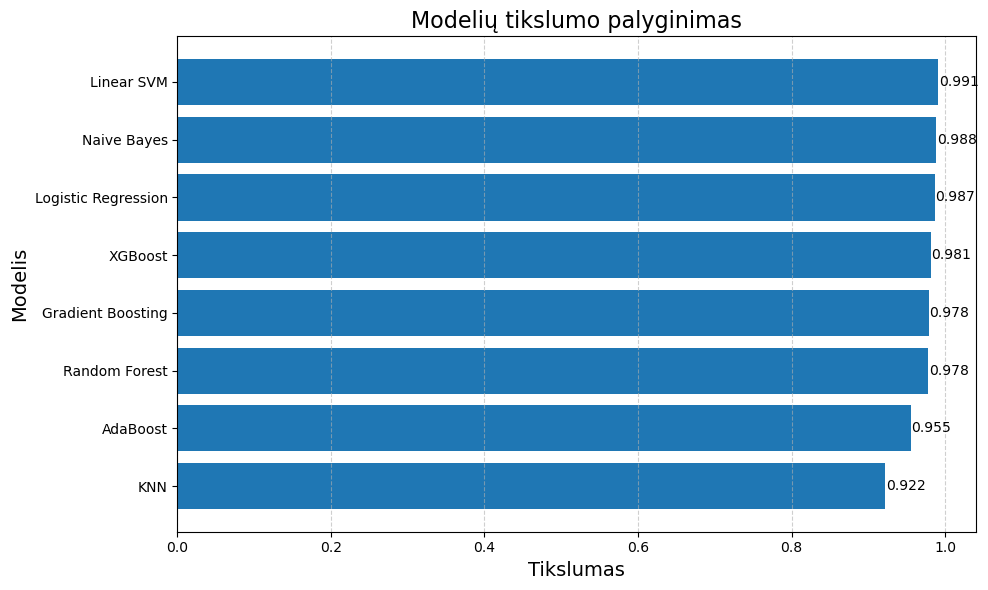

In [100]:
results_bow_df = results_bow_df.sort_values(by="Tikslumas", ascending=True)

# Nubraižome diagramą
plt.figure(figsize=(10, 6))
plt.barh(results_bow_df["Modelis"], results_bow_df["Tikslumas"])

# Pavadinimai ir stilius
plt.title("Modelių tikslumo palyginimas", fontsize=16)
plt.xlabel("Tikslumas", fontsize=14)
plt.ylabel("Modelis", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Parodome tikslumo reikšmes ant stulpelių
for i, v in enumerate(results_bow_df["Tikslumas"]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

# Pašalinsime stop words

In [101]:
bow_vectorizer = CountVectorizer()

X_bow_sw = bow_vectorizer.fit_transform(df_sw['text'])
y_bow_sw = df_sw['label']

In [102]:
X_bow_sw_train, X_bow_sw_test, y_bow_sw_train, y_bow_sw_test = train_test_split(X_bow_sw, y_bow_sw, test_size=0.2, random_state=5)

In [103]:
results_bow_sw = []
for name, model in models.items():
    print(f"🔹 Treniruojamas modelis: {name}")
    model.fit(X_bow_sw_train, y_bow_sw_train)
    y_pred = model.predict(X_bow_sw_test)
    acc = accuracy_score(y_bow_sw_test, y_pred)
    results_bow_sw.append((name, acc))
    print(f"✅ Tikslumas: {acc:.4f}")
    print(classification_report(y_bow_sw_test, y_pred, digits=3))
    print("-" * 60)

🔹 Treniruojamas modelis: Naive Bayes
✅ Tikslumas: 0.9722
              precision    recall  f1-score   support

           0      0.989     0.979     0.984       970
           1      0.870     0.924     0.896       145

    accuracy                          0.972      1115
   macro avg      0.929     0.952     0.940      1115
weighted avg      0.973     0.972     0.973      1115

------------------------------------------------------------
🔹 Treniruojamas modelis: Logistic Regression
✅ Tikslumas: 0.9740
              precision    recall  f1-score   support

           0      0.975     0.996     0.985       970
           1      0.968     0.828     0.892       145

    accuracy                          0.974      1115
   macro avg      0.971     0.912     0.939      1115
weighted avg      0.974     0.974     0.973      1115

------------------------------------------------------------
🔹 Treniruojamas modelis: Linear SVM
✅ Tikslumas: 0.9749
              precision    recall  f1-score   

In [104]:
results_bow_sw_df = pd.DataFrame(results_bow_sw, columns=["Modelis", "Tikslumas"]).sort_values(by="Tikslumas", ascending=False)
print("\n📊 Modelių palyginimas:")
print(results_bow_sw_df)


📊 Modelių palyginimas:
               Modelis  Tikslumas
2           Linear SVM   0.974888
1  Logistic Regression   0.973991
0          Naive Bayes   0.972197
3        Random Forest   0.967713
7              XGBoost   0.965022
6    Gradient Boosting   0.959641
5             AdaBoost   0.920179
4                  KNN   0.919283


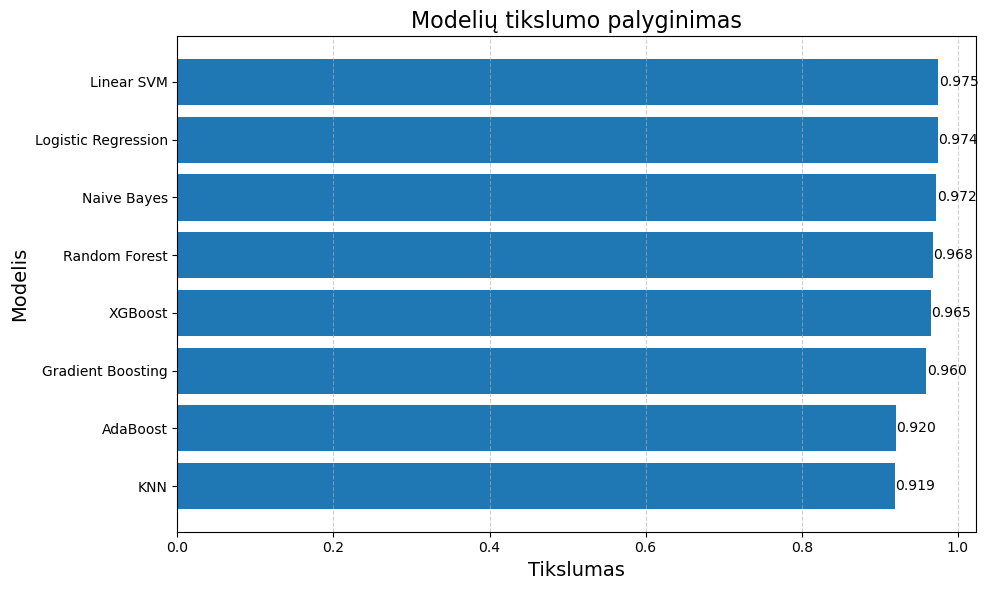

In [105]:
results_bow_sw_df = results_bow_sw_df.sort_values(by="Tikslumas", ascending=True)

# Nubraižome diagramą
plt.figure(figsize=(10, 6))
plt.barh(results_bow_sw_df["Modelis"], results_bow_sw_df["Tikslumas"])

# Pavadinimai ir stilius
plt.title("Modelių tikslumo palyginimas", fontsize=16)
plt.xlabel("Tikslumas", fontsize=14)
plt.ylabel("Modelis", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Parodome tikslumo reikšmes ant stulpelių
for i, v in enumerate(results_bow_sw_df["Tikslumas"]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center')

plt.tight_layout()
plt.show()

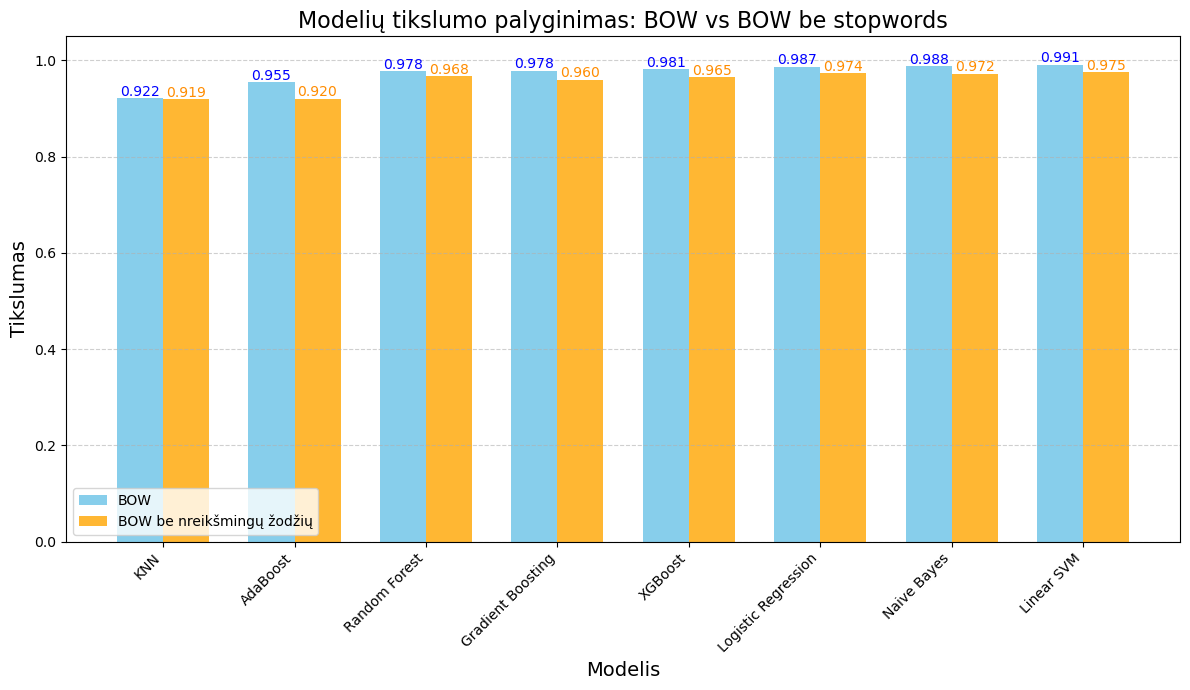

In [106]:
comparison_df = pd.merge(results_bow_df, results_bow_sw_df, on="Modelis", suffixes=('_BOW', '_BOW_SW'))

# Nustatome pozicijas
models = comparison_df["Modelis"]
x = np.arange(len(models))  # modelių pozicijos x ašyje
width = 0.35  # stulpelio plotis

# Nubraižome diagramą
plt.figure(figsize=(12, 7))

plt.bar(x - width/2, comparison_df["Tikslumas_BOW"], width, label='BOW', color='skyblue')
plt.bar(x + width/2, comparison_df["Tikslumas_BOW_SW"], width, label='BOW be nreikšmingų žodžių', color='orange', alpha=0.8)

# Ašys ir pavadinimai
plt.ylabel("Tikslumas", fontsize=14)
plt.xlabel("Modelis", fontsize=14)
plt.title("Modelių tikslumo palyginimas: BOW vs BOW be stopwords", fontsize=16)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylim(0, 1.05)  # tikslumo ašies ribos

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Pridedame tikslumo reikšmes ant stulpelių
for i in range(len(models)):
    plt.text(x[i] - width/2, comparison_df["Tikslumas_BOW"][i] + 0.005, f"{comparison_df['Tikslumas_BOW'][i]:.3f}", ha='center', color='blue')
    plt.text(x[i] + width/2, comparison_df["Tikslumas_BOW_SW"][i] + 0.005, f"{comparison_df['Tikslumas_BOW_SW'][i]:.3f}", ha='center', color='darkorange')

plt.tight_layout()
plt.show()